# Solver

In [1]:
%load_ext Cython

In [2]:
%%cython

#cython: cdivision = True

import json
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from time import time

"""
example bitmap for bitboard garden with 5 rows and 6 columns

00 01 02 03 04 05 | 06
07 08 09 10 11 12 | 13
14 15 16 17 18 19 | 20
21 22 23 24 25 26 | 27
28 29 30 31 32 33 | 34
    Dead column for ^^ shift operations
"""

cdef enum:
    PRIME = 10007
    MEM_SIZE = 50000
    
ctypedef unsigned long long uint64
ctypedef uint64 bitboard

SOLUTIONS_FILE = "solutions.csv"
    
cdef struct two_bitboards:
    bitboard a
    bitboard b
    
cdef int popcount(unsigned long long x):
    cdef int c = 0
    while x:
        x &= x - 1
        c += 1
    return c

cdef class Garden:
    
    cdef:
        public int rows, cols
        int shift_up_left, shift_up, shift_up_right, shift_left
        int shift_right, shift_down_left, shift_down, shift_down_right
        public two_bitboards garden
        int directions[8]
        bitboard MASK
    
    def __init__(self, int rows, int cols):
        self.rows = rows
        self.cols = cols
        self.shift_up = - cols - 1
        self.shift_down = cols + 1
        self.shift_left = - 1
        self.shift_right = 1
        self.shift_up_left = self.shift_up + self.shift_left
        self.shift_up_right = self.shift_up + self.shift_right
        self.shift_down_left = self.shift_down + self.shift_left
        self.shift_down_right = self.shift_down + self.shift_right
        self.directions = [
            self.shift_up_left,
            self.shift_up,
            self.shift_up_right,
            self.shift_left,
            self.shift_right,
            self.shift_down_left,
            self.shift_down,
            self.shift_down_right
        ]
        self.garden.a = 0
        self.garden.b = 0
        self.MASK = 0
        cdef int i,j
        for i in range(rows):
            for j in range(cols):
                self.MASK ^= <bitboard>1 << i * (cols + 1) + j
                
    cpdef bitboard hash_to_bitboard(self, bitboard h):
        """
        Converts a dense bit-representation of a garden to the expanded one with a dead column
        """
        cdef:
            bitboard row_mask
            bitboard b = 0
            int shift = 0
        row_mask = (<bitboard> 1 << self.cols) - 1
        while h:
            b |= (h & row_mask) << shift
            h >>= (self.cols)
            shift += self.cols + 1
        return b
    
    cpdef bitboard bitboard_to_hash(self, bitboard b):
        """
        Converts the expanded bit-representation of a garden to a dense one
        """
        cdef:
            bitboard row_mask
            bitboard h = 0
            int shift = 0
        row_mask = (<bitboard> 1 << self.cols) - 1
        while b:
            h |= (h & row_mask) << shift
            b >>= (self.cols + 1)
            shift += self.cols
        return h
            

    cdef void adjacent(self, bitboard b, bitboard *adjacency):
        """
        Computes the adjacency of bitboard b
        returns 9 adjacency bitboards for if there are == i neighbouring plants in this index
        """
        cdef int i, j
        cdef int shift
        cdef bitboard neighbour
        adjacency[0] = self.MASK
        for j in range(1, 9):
            adjacency[j] = 0
        for i in range(8):
            shift = self.directions[i]
            if shift > 0:
                neighbour = b << shift
            else:
                neighbour = b >> -shift
            for j in range(i + 1, 0, -1):
                adjacency[j] |= adjacency[j-1] & neighbour
        for j in range(9):
            adjacency[j] &= ~b & self.MASK
        for j in range(8):
            adjacency[j] &= ~adjacency[j+1]
        
        return
    
    cpdef object adjacent_popcounts(self, bitboard b):
        cdef bitboard[9] adjacency
        self.adjacent(b, adjacency)
        return [popcount(adjacency[i]) for i in range(9)]

    cdef int score(self, int* rewards):
        """
        Scores the garden based on the array rewards. rewards[i] is the score to be given if an empty plot
        has at least i neighbours.
        
        e.g. for a plant that requires 2 neighbours
        rewards = [0, 0, 1, 1, 1, 1, 1, 1, 1]
        
        e.g. for clover:
        rewards = [0, 0, 1, 1, 8, 7, 7, 7, 7]
        """
        cdef int s = 0
        cdef int i
        cdef bitboard[9] adjacency
        self.adjacent(self.garden.a, adjacency)
        for i in range(9):
            s += rewards[i] * popcount(adjacency[i])
        return s
    
    cdef int score2(self, int rewards[9][9]):
        cdef:
            int s = 0
            int i, j
            bitboard[9] a_adjacency
            bitboard[9] b_adjacency
        self.adjacent(self.garden.a, a_adjacency)
        self.adjacent(self.garden.b, b_adjacency)
        for i in range(9):
            for j in range(9):
                s += rewards[i][j] * popcount(a_adjacency[i] & b_adjacency[j])
        return s
    
    cdef int scan_solve(self, int* rewards, bitboard* solutions, int* n_solutions, double fps = 1/24.):
        """
        Solve by brute force
        """
        cdef:
            bitboard x, b
            int best = 0
            int score
            int i
            int max_reward
            int max_plant_impact
            int popcnt
            double t0
        print("Checking for cached solution.")
        score, p_solutions = self.get_cached_solution(json.dumps([rewards[i] for i in range(9)]))
        if len(p_solutions) > 0:
            print("Cached solution found.")
            n_solutions[0] = len(p_solutions)
            for i in range(n_solutions[0]):
                solutions[i] = p_solutions[i]
            return score
        print("Scanning for solution.")
        n_solutions[0] = 0
        #two values to calculate upper bounds to the score based solely on plant count
        max_reward = max([rewards[i] for i in range(9)])
        max_plant_impact = max([(8 * rewards[i]/i) + (8*rewards[i]%i != 0) for i in range(1, 9)])
        t0 = time()
        x=0
        for x in range( <bitboard> 1 << (self.rows * self.cols)):
            if x % 1000 == 0 and time() - t0 > fps:
                t0 = time()
                self.display(
                    100. * x / (<bitboard> 1 << (self.rows * self.cols)),
                    f"Best score: {best:5d}. Number of solutions: {n_solutions[0]:7d}."
                )
            popcnt = popcount(x)
            #two upper-bounds to the score of a garden based solely on plant count
            if (self.rows * self.cols - popcnt) * max_reward < best:
                continue
            if popcnt * max_plant_impact < best:
                continue
            b = self.hash_to_bitboard(x)
            self.garden.a = b
            score = self.score(rewards)
            if score > best:
                best = score
                solutions[0] = x
                n_solutions[0] = 1
            elif score == best:
                solutions[n_solutions[0]%MEM_SIZE] = x
                n_solutions[0] += 1  
        self.push_solutions(
            json.dumps([rewards[i] for i in range(9)]), 
            best,
            [solutions[i] for i in range(n_solutions[0])]
        )
        return best
    
    cdef int list_solve(
        self, int* rewards, bitboard* solutions, int* n_solutions, bitboard* candidates, int n_candidates
    ):
        """
        From the list candidates, return the best configurations of one plant variety
        """
        cdef int i, best
        best = 0
        n_solutions[0] = 0
        for i in range(n_candidates):
            self.garden.a = self.hash_to_bitboard(candidates[i])
            score = self.score(rewards)
            if score > best:
                best = score
                solutions[0] = candidates[i]
                n_solutions[0] = 1
            elif score == best:
                solutions[n_solutions[0]%MEM_SIZE] = candidates[i]
                n_solutions[0] += 1
        return best
    
    cdef int list_solve_2(
        self, int rewards[9][9], two_bitboards* solutions, int* n_solutions, bitboard* candidates, int n_candidates
    ):
        """
        From a list of skeleton candidates, return the best configurations of two plant varieties
        """

        cdef:
            int n_set_bits
            bitboard set_bits[64]
            bitboard x
            int i, k
            n_pairs
            uint64 j
            int best
            two_bitboards candidate
        best = 0
        n_solutions[0] = 0
        for i in range(n_candidates):
            self.display(
                100. * i / n_candidates, f"Best score: {best:5d}. Number of solutions: {n_solutions[0]:7d}."
            )
            n_set_bits = 0
            x = candidates[i]
            while x:
                set_bits[n_set_bits] = x & -x
                x &= x - 1
                n_set_bits += 1
            for j in range(2 ** n_set_bits):
                #use the binary representation of j to iterate through all 
                #permutations of splitting the set bits between a and b
                candidate.a = 0
                candidate.b = 0
                for k in range(n_set_bits):
                    if (j >> k) & 1:
                        candidate.a |= set_bits[k]
                    else:
                        candidate.b |= set_bits[k]
                self.garden.a = self.hash_to_bitboard(candidate.a)
                self.garden.b = self.hash_to_bitboard(candidate.b)
                score = self.score2(rewards)
                if score > best:
                    best = score
                    solutions[0] = candidate
                    n_solutions[0] = 1
                elif score == best:
                    solutions[n_solutions[0]%MEM_SIZE] = candidate
                    n_solutions[0] += 1
        return best
        
    def get_cached_solution(self, rewards):
        df = pd.read_csv(SOLUTIONS_FILE)
        df = df[(df["rows"] ==self.rows) & (df["columns"] == self.cols) & (df["rewards"] == rewards)]
        assert(len(df) == 0 or df["score"].min() == df["score"].max())
        if len(df) > 0:
            return df["score"].min(), list(df["garden"])
        else:
            return 0, []

    def push_solutions(self, rewards, score, solutions):
        df = pd.DataFrame([
            {
                "rows": self.rows,
                "columns": self.cols,
                "rewards": rewards,
                "score": score,
                "garden": solution
            } for solution in solutions
        ])
        df = pd.concat([df, pd.read_csv(SOLUTIONS_FILE)], ignore_index = True).drop_duplicates()
        df.to_csv(SOLUTIONS_FILE, index = False)
        
    def display(self, progress, message = ""):
        print(f"\r{progress:5.1f}% complete. " + message, end = "")
    
    def p_solve(self, rewards, neighbours = None):
        """
        Solve the garden with the metric rewards, using neighbours as a hint.
        Neighbours says that the optimal solution is close to optimizing for having as 
        many plots with neighbours-adjacent plants
        """
        cdef bitboard[MEM_SIZE] solutions
        cdef bitboard[MEM_SIZE] candidates
        cdef int n_candidates
        cdef int n_solutions
        cdef int[9] r
        
        if neighbours is not None:
            #get candidate solutions from the neighbours hint
            r = [0 if i < neighbours else 1 for i in range(9)]
            score = self.scan_solve(r, candidates, &n_candidates)
            self.display(100, f"Best score: {score:5d}. Number of solutions: {n_candidates:7d}.")
            print()
            r = rewards
            print("scoring candidate skeletons")
            score = self.list_solve(r, solutions, &n_solutions, candidates, n_candidates)
            self.display(100, f"Best score: {score:5d}. Number of solutions: {n_solutions:7d}.")
            print()
            
        else:
            r = rewards
            score = self.scan_solve(r, solutions, &n_solutions)
            self.display(100, f"Best score: {score:5d}. Number of solutions: {n_solutions:7d}.")
            print()
        return score, list(solutions)[:n_solutions], n_solutions
    
    
    def p_solve_2(self, neighbours, rewards = None):
        """
        neighbours is a tuple with the required number of each plant
        rewards is if there are custom weights to give to the optimizer
        
        e.g. a typical situation would be:
        neighbours = (1, 1)
        rewards = {(1, 1): 102, (2, 0): -1, (0, 2): -1}
        
        This configuration would maximize the number of plots adjacent to at least one
        of each plant, but then try to avoid putting two or more of the same plant 
        adjacent to any plot.
        """
        
        cdef:
            int[9] rewards_skeleton
            int[9][9] rewards_2d
            bitboard[MEM_SIZE] candidates
            two_bitboards[MEM_SIZE] solutions
            int i, j, n_solutions, n_candidates, score
        
        rewards_skeleton = [i>=sum(neighbours) for i in range(9)]
        score = self.scan_solve(rewards_skeleton, candidates, &n_candidates)
        self.display(100, f"Best score: {score:5d}. Number of solutions: {n_candidates:7d}.")
        print()
        rewards = rewards or {neighbours : 1}
        
        #zero-out the reward array
        for i in range(9):
            for j in range(9):
                rewards_2d[i][j] = 0
        
        #build 2-d reward array
        for neighbour, reward in rewards.items():
            for i in range(9):
                for j in range(9):
                    if i >= neighbour[0] and j >= neighbour[1]:
                        rewards_2d[i][j] += reward
        print("Permuting and scoring candidate skeletons")
        score = self.list_solve_2(rewards_2d, solutions, &n_solutions, candidates, n_candidates)
        self.display(100, f"Best score: {score:5d}. Number of solutions: {n_solutions:7d}.")
        print()
        return score, list(solutions)[:n_solutions], n_solutions
    

# Solver UI

In [3]:
def bitboard_to_np(x, rows, cols):
    bits = list(f"{x:b}")
    bits = [0]*(rows*cols - len(bits)) + bits
    return np.array([int(y) for y in bits]).reshape(rows, cols)

def plot_solutions(s):
    plots_width = 10
    rows = int((len(s) - 1) / plots_width + 1)
    f, a = plt.subplots(rows,plots_width)
    f.set_figwidth(16)
    f.set_figheight(16 / plots_width * rows)
    a = a.reshape(-1)
    i = 0
    for x in s:
        if isinstance(x, int):
            m = bitboard_to_np(x, g.rows, g.cols)
        else:
            m = bitboard_to_np(x['a'], g.rows, g.cols) + 2 * bitboard_to_np(x['b'], g.rows, g.cols)
        a[i].imshow(m , cmap = 'Greens', aspect = 'equal', vmax = 1.75)
        a[i].set_xticks([])
        a[i].set_yticks([])
        i += 1
    for j in range(i, len(a)):
        a[j].set_axis_off()

Checking for cached solution.
Cached solution found.
100.0% complete. Best score:     6. Number of solutions:       8.
scoring candidate skeletons
100.0% complete. Best score: 458852. Number of solutions:       8.
score: 458852. configurations: 8


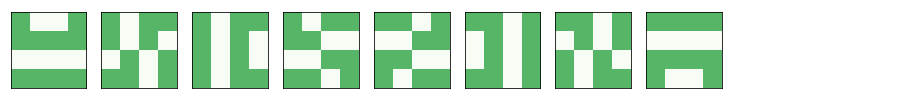

In [14]:
i = 4
j = 4
neighbours = 4
rewards = [0, 0, 9965, 9965, 79713, 70000, 70000, 70000, 70000] #clover

# rewards = [0, 0, 9965, 9965, 79713, 70000, 70000, 70000, 70000] #clover
# rewards = [0, 0, 1, 1, 1, 1, 1, 1, 1] #typical
# rewards = [0,0,0,1,1,1,1,1,1] #shriekbulb via duketater
# rewards = [0,0,0,0,0,1,1,1,1] #shriekbulb via elderwort/queenbeet
# rewards = [0,0,0,0,0,1,1,1,1] #shriekbulb via queenbeet
# rewards = [0,0,0, 0, 1, 1, 1, 1, 1] #shiekbulb via doughshroom
# rewards = [0, 0, 0, 0, 0, 0, 0, 0, 1] #juicy queenbeet



g = Garden(i, j)
score, solutions, n_solutions = g.p_solve(rewards, neighbours)
print(f"score: {score}. configurations: {n_solutions}")
s = solutions[:100]
plot_solutions(s)


Checking for cached solution.
Cached solution found.
100.0% complete. Best score:    10. Number of solutions:      36.
Permuting and scoring candidate skeletons
100.0% complete. Best score:   998. Number of solutions:       8.
score: 998. configurations: 8


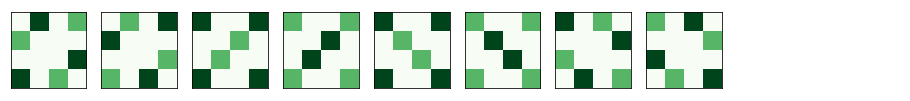

In [5]:
i = 4
j = 4
#typical
neighbours = (1,1)
rewards = {(1,1):100, (2,0):-1, (0,2):-1} #penalize same plant mutations


# everdaisy
# neighbours = (3, 3)
# rewards = {(3,3):1}

g = Garden(i, j)
score, solutions, n_solutions = g.p_solve_2(neighbours, rewards)
print(f"score: {score}. configurations: {n_solutions}")
s = solutions[:100]
plot_solutions(s)

# Infographics

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

def golden_clover_chance(adjacency):
    """
    adjacency is the number of neighbouring clovers for each empty plot.
    If there are 2-4 clovers, then there is p chance for a    golden clover to be added to the push list
    If there are 4+  clovers, then there is q chance for a    golden clover to be added to the push list
    If there are 2-4 clovers, then there is w chance for an ordinary clover to be added to the push list
    If more than one plant is added to the push list then ONLY ONE is chosen
    
    adjacent clovers : chance for golden clover
               (2-3) : p * (1-w/2)
                   4 : p + q - p * q - 1 / 2 * p * w - 1 / 2 * q * w - 2 / 3 * p * q * w
               (5-8) : q
               
    
    """
    p = 0.0001
    q = 0.0007
    w = 0.007
    inverse_probability = 1
    plot_probability = p * (1-w/2)
    for a in adjacency[2:4]:
        inverse_probability *= (1 - plot_probability) ** a
    plot_probability = p + q - p * q - 1. / 2. * p * w - 1. / 2. * q * w - 2. / 3. * p * q * w
    inverse_probability *= (1 - plot_probability) ** adjacency[4]
    plot_probability = q
    for a in adjacency[5:9]:
        inverse_probability *= (1 - plot_probability) ** a
    return 1 - inverse_probability
    
def bitboard_to_np(x, rows, cols):
    bits = list(f"{x:b}")
    bits = [0]*(rows*cols - len(bits)) + bits
    return np.array([int(y) for y in bits]).reshape(rows, cols)

def build_data(rewards, neighbours = None, score_title = 'score', score_function = lambda x: x, override = None):
    data = {}
    for i in range(2, 7):
        for j in range(i, i+2):
            if j == 7:
                continue
            ij_data = {}
            data[(i,j)] = ij_data
            print(f"{i}x{j} garden")
            g = Garden(i, j)
            if isinstance(rewards, list):
                score, solutions, n_solutions = g.p_solve(rewards, neighbours)
            else:
                score, solutions, n_solutions = g.p_solve_2(neighbours, rewards)
            ij_data["score"] = score_function(score)
            ij_data["configurations"] = n_solutions
            if isinstance(solutions[0], int):
                ij_data["a"] = solutions[0]
                ij_data["b"] = 0
            else:
                ij_data.update(solutions[0])
            if override is not None:
                ij_data.update(override.get((i,j), {}))
    return data
            

def make_infographic(data, title, f = None):
    df_data = []
    for i in range(2,7):
        for j in range(i,i+2):
            if j > 6:
                continue
            df_data.append((f"{i}x{j}", data[i,j]["score"], data[i,j]["configurations"]))
    df = pd.DataFrame(df_data, columns = ["size", data.get("score_name", "score"), "configurations"])
    if f is None:
        f = plt.figure(tight_layout = True)
    f.suptitle(title, fontsize = 48, fontweight = 'bold')
    gs = f.add_gridspec(10, 37)
    gs.update(wspace=0., hspace=0.)
    f.set_figwidth(31)
    f.set_figheight(9)
    table_axes = f.add_subplot(gs[:,:12])
    table_axes.axis("off")
    table = table_axes.table(
        df.values,
        [
            [
            'lightcyan' if i%2 else 'paleturquoise' for j in range(df.values.shape[1])
            ] for i in range(df.values.shape[0])
        ],
        colLabels = df.columns, 
        loc = 'center', 
        bbox = [0,0,1,1], 
        cellLoc='center'
    )
    table.auto_set_column_width([0, 1, 2])
    table.auto_set_font_size(False)
    table.set_fontsize(36)
    a = []
    a.append(f.add_subplot(gs[1:3,12:14]))
    a.append(f.add_subplot(gs[1:3,15:18]))
    a.append(f.add_subplot(gs[1:4,19:22]))
    a.append(f.add_subplot(gs[1:4,27:31]))
    a.append(f.add_subplot(gs[1:5,33:37]))
    a.append(f.add_subplot(gs[6:,32:37]))
    a.append(f.add_subplot(gs[5:,26:31]))
    a.append(f.add_subplot(gs[5:,19:25]))
    a.append(f.add_subplot(gs[4:,12:18]))
    i=0
    for rows in range(2, 7):
        for cols in range(rows, rows+2):
            if cols == 7:
                continue
            x = data[(rows,cols)]
            m = bitboard_to_np(x['a'], rows, cols) + 2 * bitboard_to_np(x['b'], rows, cols)
            a[i].imshow(m , cmap = 'Greens', aspect = 'auto', vmax = 1.75)
            a[i].set_xticks([])
            a[i].set_yticks([])
            a[i].set_xticklabels([])
            a[i].set_yticklabels([])
            a[i].set_title(f"{rows}x{cols}", fontsize = 36)
            i += 1
    return f

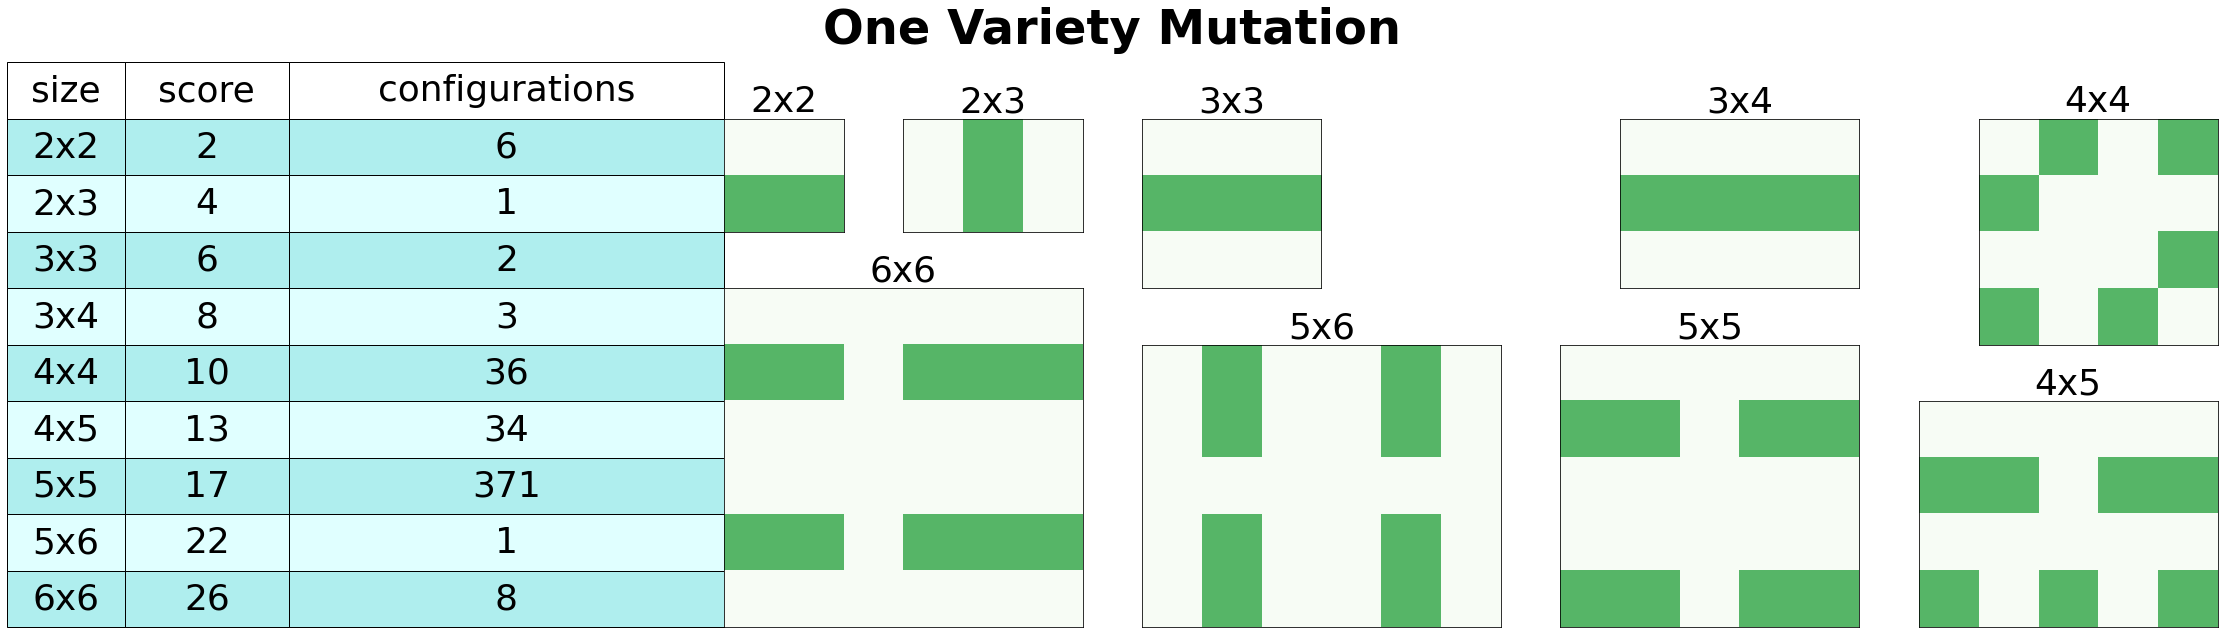

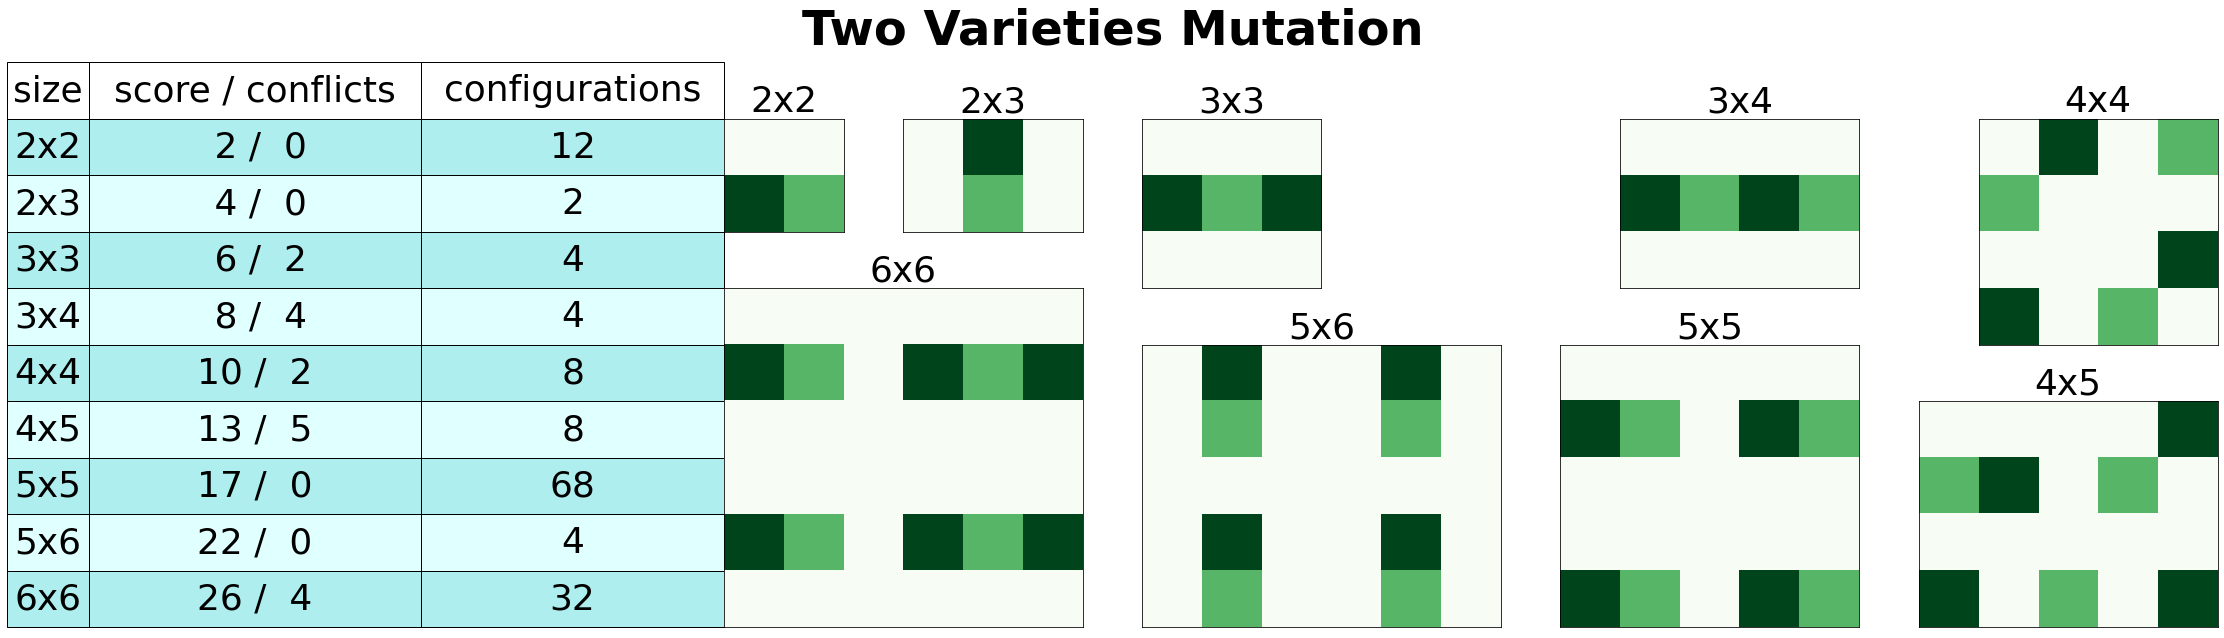

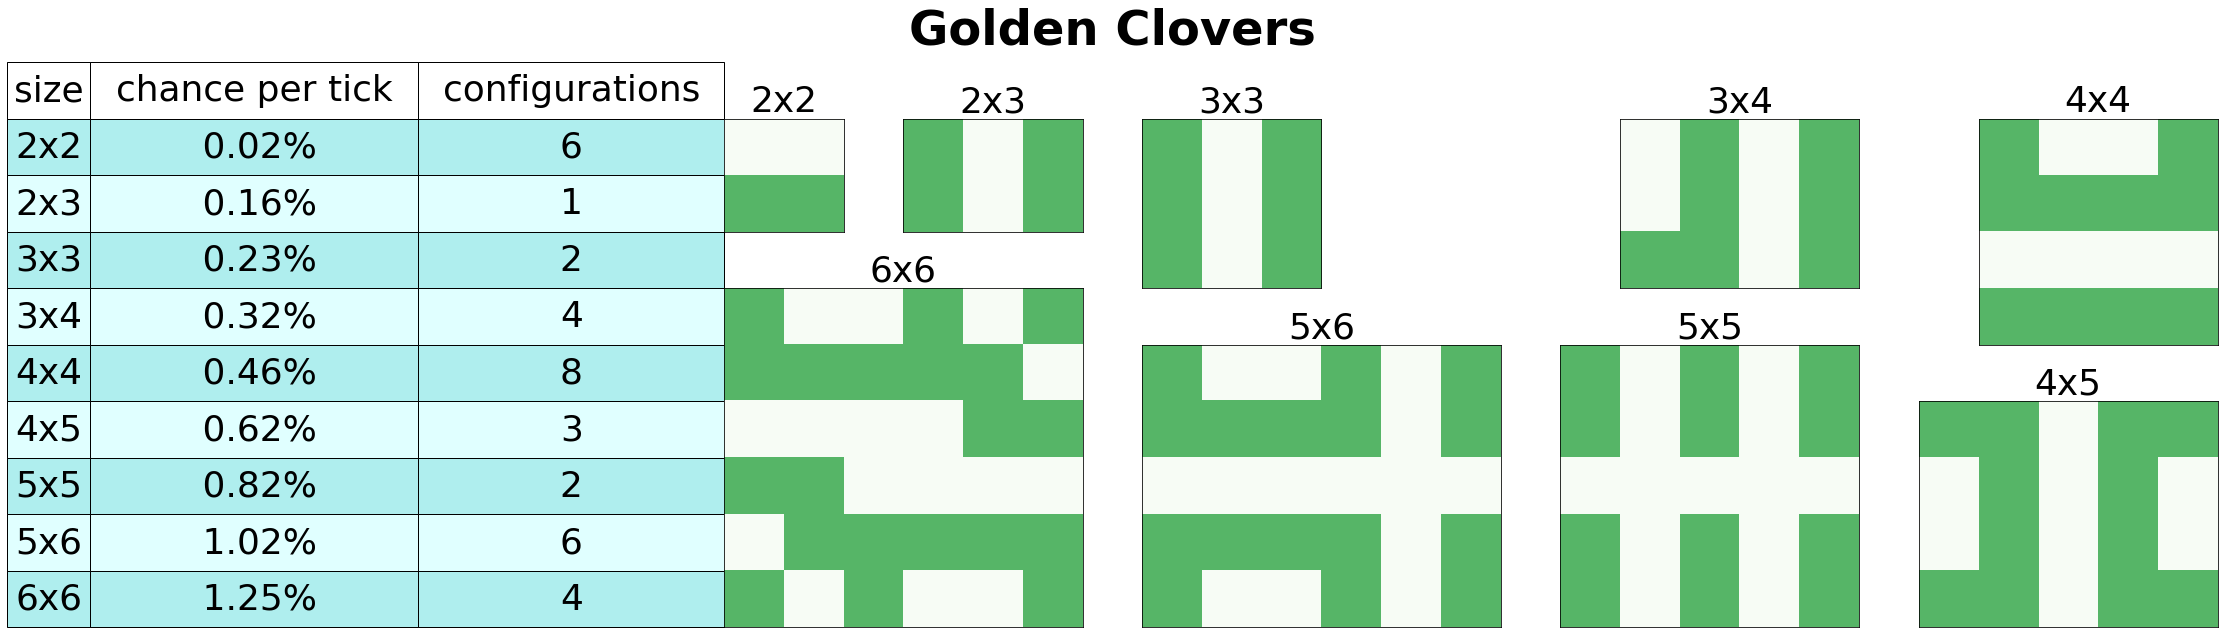

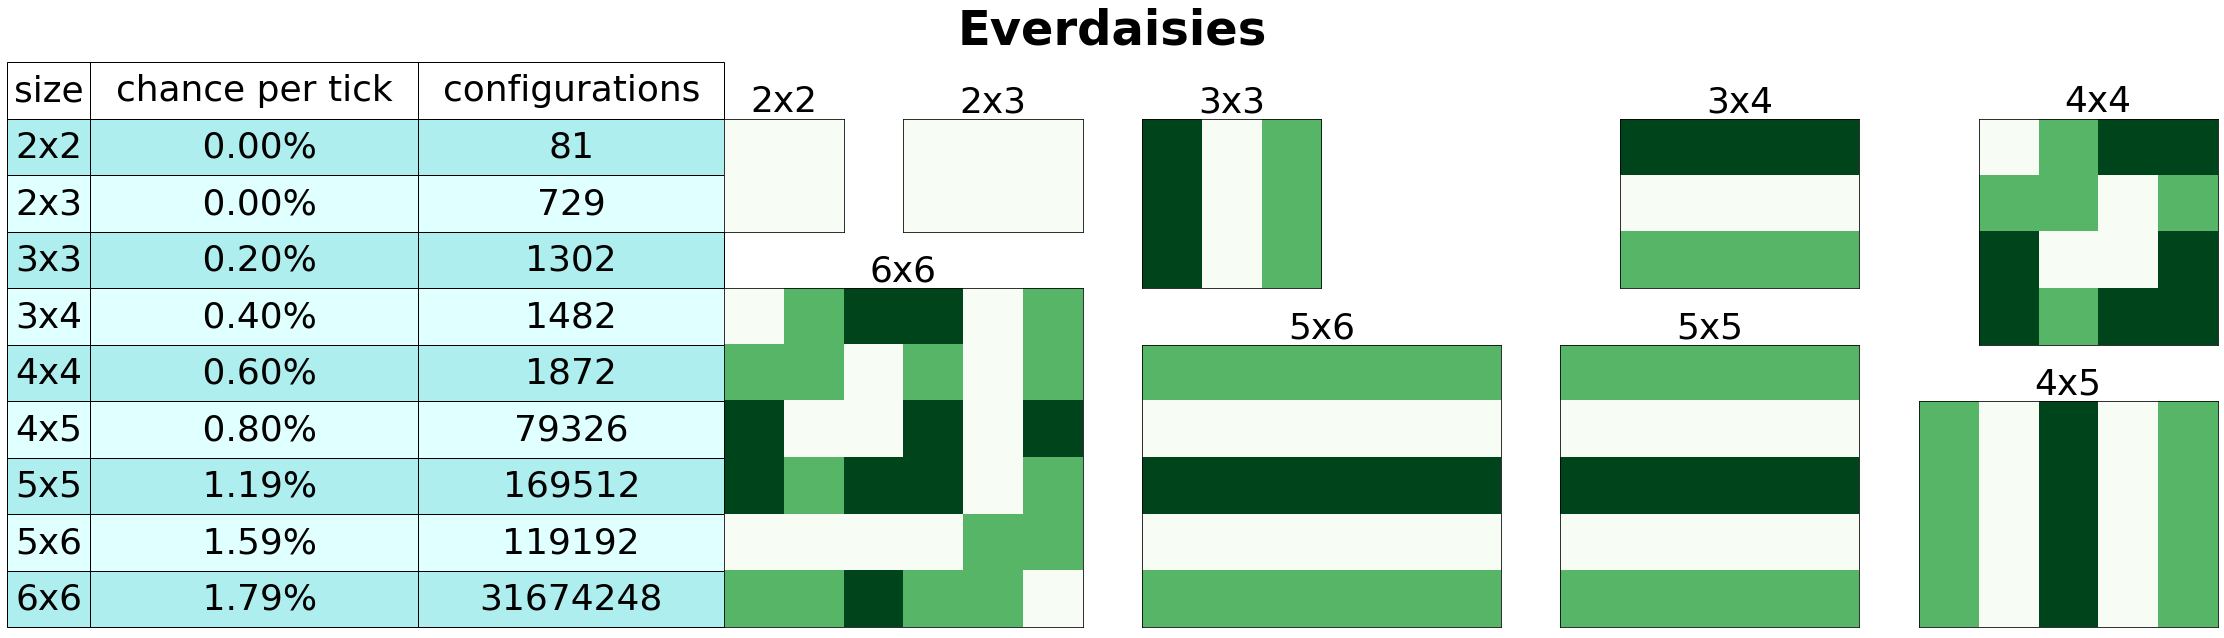

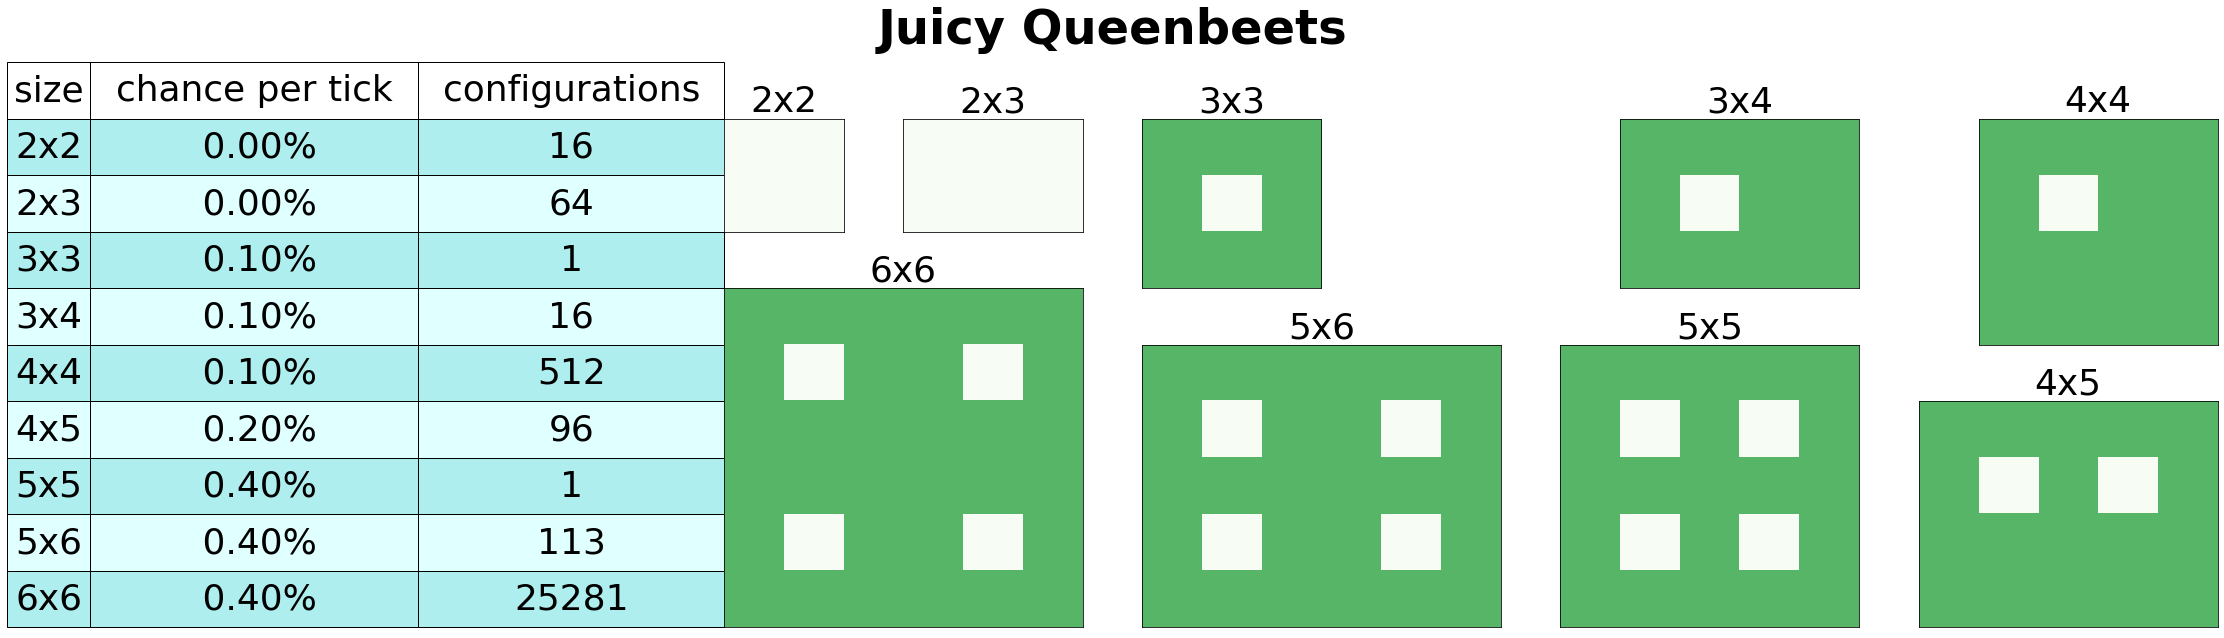

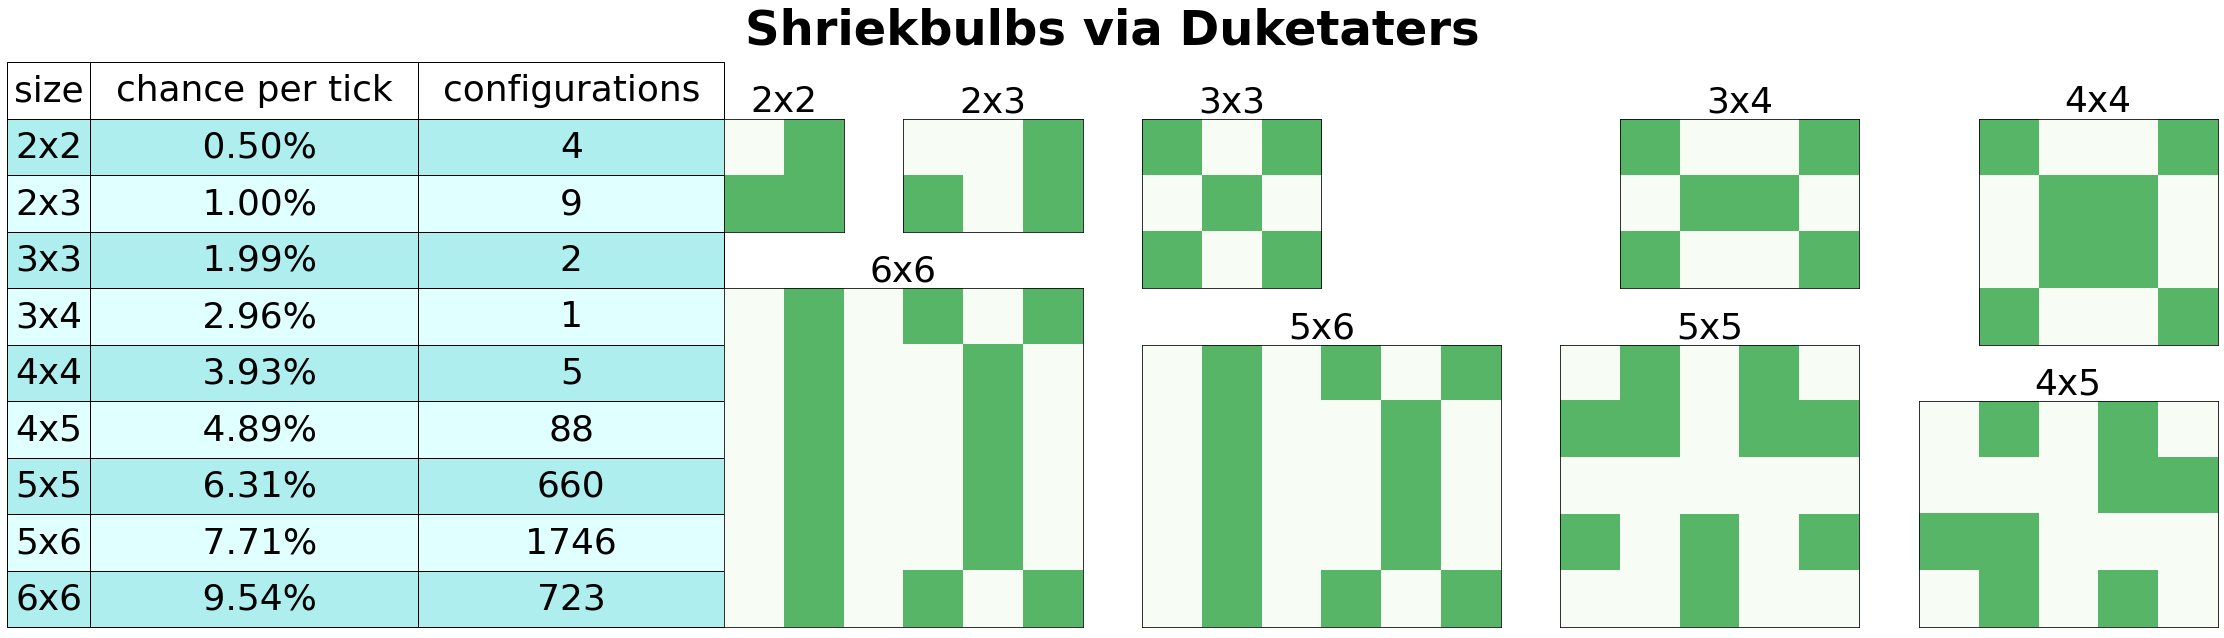

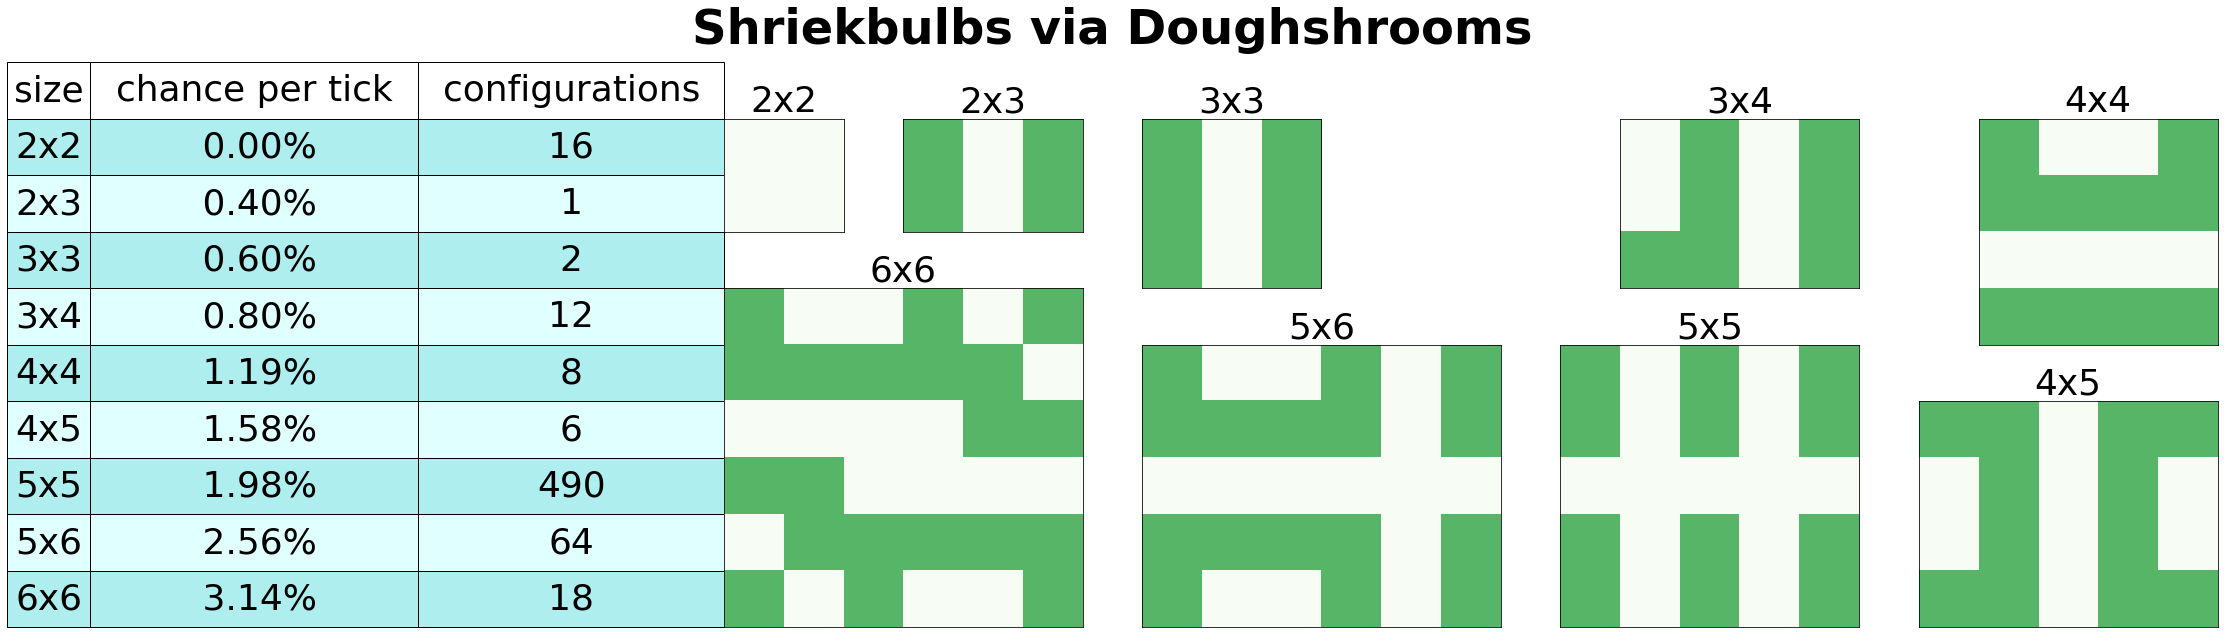

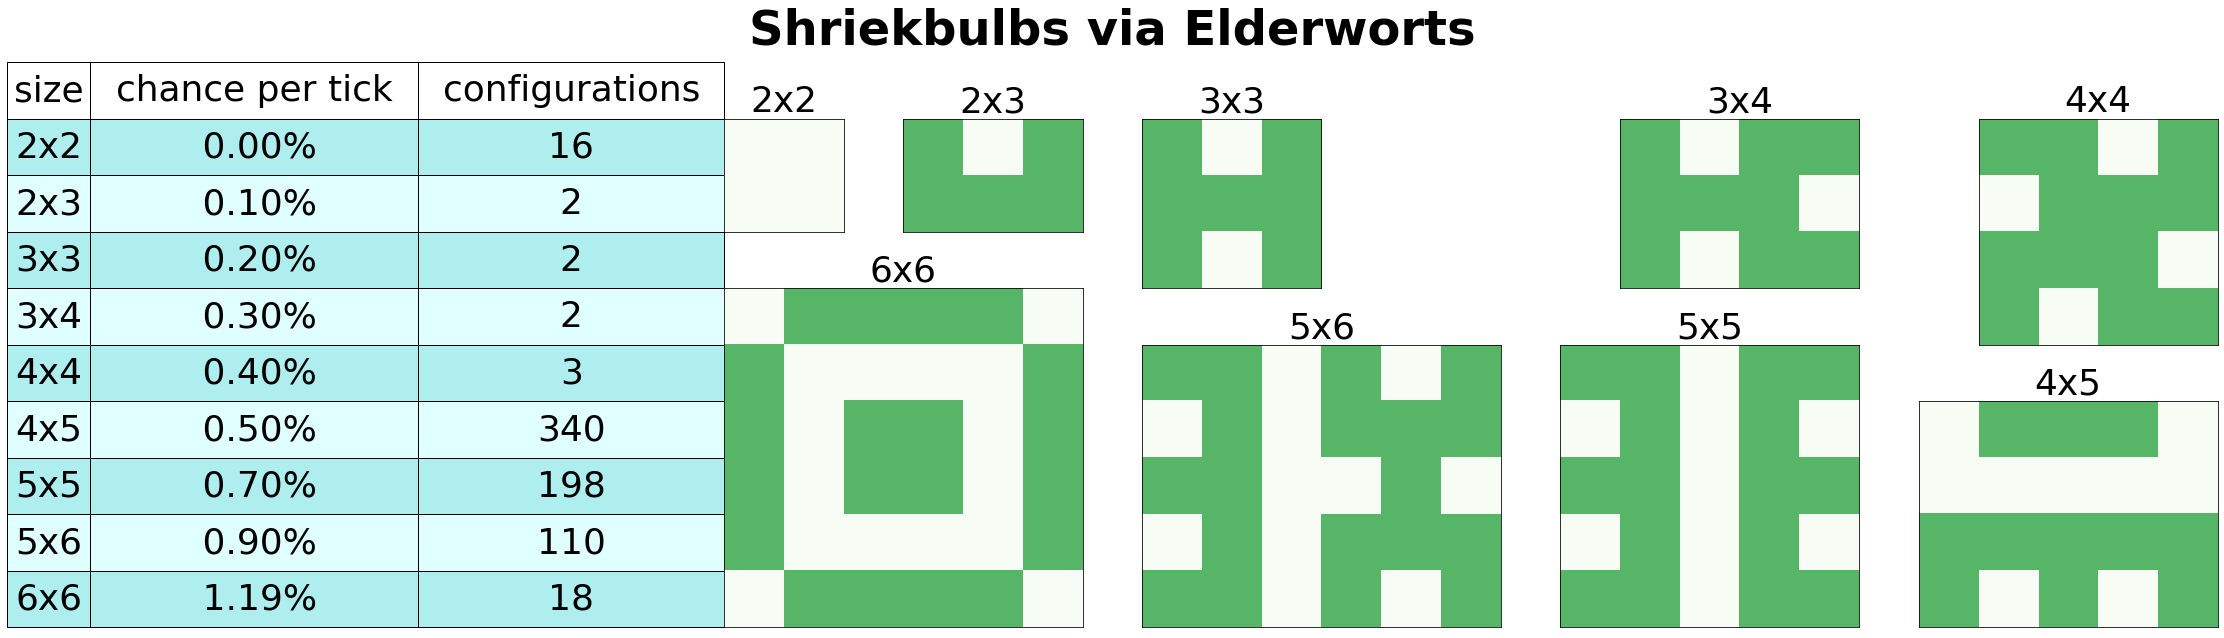

In [15]:
LIKELIHOOD = 'chance per tick'

one_variety_aesthetic = {
    (4,4): {'a': 22554}
}
one_variety_data = build_data([0, 0, 1, 1, 1, 1, 1, 1, 1], 2, override = one_variety_aesthetic)
two_variety_aesthetic = {
    (4,4): {'a': 6146, 'b': 16408}
}
two_variety_data = build_data({(1,1):100, (2,0):-1, (0,2):-1}, (1,1), override = two_variety_aesthetic)
for key in two_variety_data:
    s = two_variety_data[key].get("score")
    if s is not None:
        two_variety_data[key]["score"] = f"{round(s/100,0):2.0f} / {round(s,-2) - s:2.0f}"
two_variety_data["score_name"] = "score / conflicts"
clover_reward = [0, 0, 9965, 9965, 79713, 70000, 70000, 70000, 70000]#ppb chance of clover per tick
clover_data = build_data(clover_reward, neighbours=4, override = {(4,5): {'a': 895323}})
for key in clover_data:
    bitboard = clover_data[key].get("a")
    if bitboard is not None:
        garden = Garden(*key)
        likelihood = golden_clover_chance(garden.adjacent_popcounts(garden.hash_to_bitboard(bitboard)))
        clover_data[key]["score"] = f"{100. * likelihood:5.2f}%"
clover_data["score_name"] = LIKELIHOOD
#pre-computed
everdaisy_data = {
    (2,2): {'score': f"{100.*(1-(1-0.002)**0):5.2f}%", 'configurations': 81,       'a': 0, 'b': 0},
    (2,3): {'score': f"{100.*(1-(1-0.002)**0):5.2f}%", 'configurations': 729,      'a': 0, 'b': 0},
    (3,3): {'score': f"{100.*(1-(1-0.002)**1):5.2f}%", 'configurations': 1302,     'a': 73, 'b': 292},
    (3,4): {'score': f"{100.*(1-(1-0.002)**2):5.2f}%", 'configurations': 1482,     'a': 15, 'b': 3840},
    (4,4): {'score': f"{100.*(1-(1-0.002)**3):5.2f}%", 'configurations': 1872,     'a': 19716, 'b': 12443},
    (4,5): {'score': f"{100.*(1-(1-0.002)**4):5.2f}%", 'configurations': 79326,    'a': 575025, 'b': 135300},
    (5,5): {'score': f"{100.*(1-(1-0.002)**6):5.2f}%", 'configurations': 169512,   'a': 32505887, 'b': 31744},
    (5,6): {'score': f"{100.*(1-(1-0.002)**8):5.2f}%", 'configurations': 119192,   'a': 1056964671, 'b': 258048},
    (6,6): {'score': f"{100.*(1-(1-0.002)**9):5.2f}%", 'configurations': 31674248, 'a': 19142873334, 'b': 12894781448},
    'score_name': LIKELIHOOD
}
juicy_queenbeet_aesthetic = {
    (2,2): {'a': 0},
    (2,3): {'a': 0},
    (3,3): {'a': 495},
    (3,4): {'a': 4031},
    (4,4): {'a': 64511},
    (4,5): {'a': 1038335},
    (5,5): {'a': 33226431},
    (5,6): {'a': 1069022079},
    (6,6): {'a': 68417485695}
}
#p = q - q^2 - 5/3q^3 where q = 0.001 (duketaters and shriekbulbs)
#p = 0.000998998
juicy_queenbeet_data = build_data(
    [0, 0, 0, 0, 0, 0, 0, 0, 1], 
    score_function = lambda x : f"{100 * (1-(1-0.000998998) ** x):5.2f}%",
    override = juicy_queenbeet_aesthetic)
juicy_queenbeet_data['score_name'] = LIKELIHOOD
shriek_duke_aesthetic = {
    (3,3): {'a': 341},
    (4,4): {'a': 38505},
    (4,5): {'a': 331530},
    (5,5): {'a': 11371172},
    (5,6): {'a': 357115029},
    (6,6): {'a': 22855361685}
}
shriek_duke_data = build_data(
    [0, 0, 0, 1, 1, 1, 1, 1, 1], 
    score_function = lambda x : f"{100. * (1 - (1 - 0.005) ** x):5.2f}%",
    override = shriek_duke_aesthetic
)
shriek_duke_data["score_name"] = LIKELIHOOD
shriek_dough_aesthetic = {
    (4,5): {'a': 895323},
    (5,5): {'a': 22708917},
    (5,6): {'a': 636751717},
    (6,6): {'a': 40769619945}
}
#p = q-1/2*q*w, where q=0.002, w=0.005 (crumbspore)
#p = 0.001995
shriek_dough_data = build_data(
    [0, 0, 0, 0, 1, 1, 1, 1, 1], 
    score_function = lambda x : f"{100. * (1 - (1 - 0.001995) ** x):5.2f}%",
    override = shriek_dough_aesthetic
)
shriek_dough_data["score_name"] = LIKELIHOOD
shriek_elderwort_aesthetic = {
    (4,4): {'a': 55275},
    (4,5): {'a': 459765},
    (5,5): {'a': 28667227},
    (5,6): {'a': 895428085}
}
shriek_elderwort_data = build_data(
    [0, 0, 0, 0, 0, 1, 1, 1, 1], 
    score_function = lambda x : f"{100 * (1 - (1 - 0.001) ** x):5.2f}%",
    override = shriek_elderwort_aesthetic
)
shriek_elderwort_data["score_name"] = LIKELIHOOD

clear_output()

figs = []
figs.append(make_infographic(one_variety_data, "One Variety Mutation"))
figs.append(make_infographic(two_variety_data, "Two Varieties Mutation"))
figs.append(make_infographic(clover_data, "Golden Clovers"))
figs.append(make_infographic(everdaisy_data, "Everdaisies"))
figs.append(make_infographic(juicy_queenbeet_data, "Juicy Queenbeets"))
figs.append(make_infographic(shriek_duke_data, "Shriekbulbs via Duketaters"))
figs.append(make_infographic(shriek_dough_data, "Shriekbulbs via Doughshrooms"))
figs.append(make_infographic(shriek_elderwort_data, "Shriekbulbs via Elderworts"))



## Save as image

In [17]:
#Saving and deleting images... would rather use temp files, but this workaround is all I care to figure out right now

from PIL import Image
import os

for i,f in enumerate(figs):
    f.savefig(f"temp{i}.png")
images = [Image.open(f"temp{i}.png") for i in range(8)]
widths, heights = zip(*(i.size for i in images))
width = max(widths)
height = max(heights)
infographic = Image.new('RGB', (width * 2, height * 4))
y_offset = 0
for i, im in enumerate(images):
    infographic.paste(im, (width * (i%2) , height * int(i/2)))
    if i % 2 == 1:
        y_offset += im.size[1]
infographic.save('infographic.png')
for i in range(8):
    os.remove(f"temp{i}.png")


# Custom Infographics Template

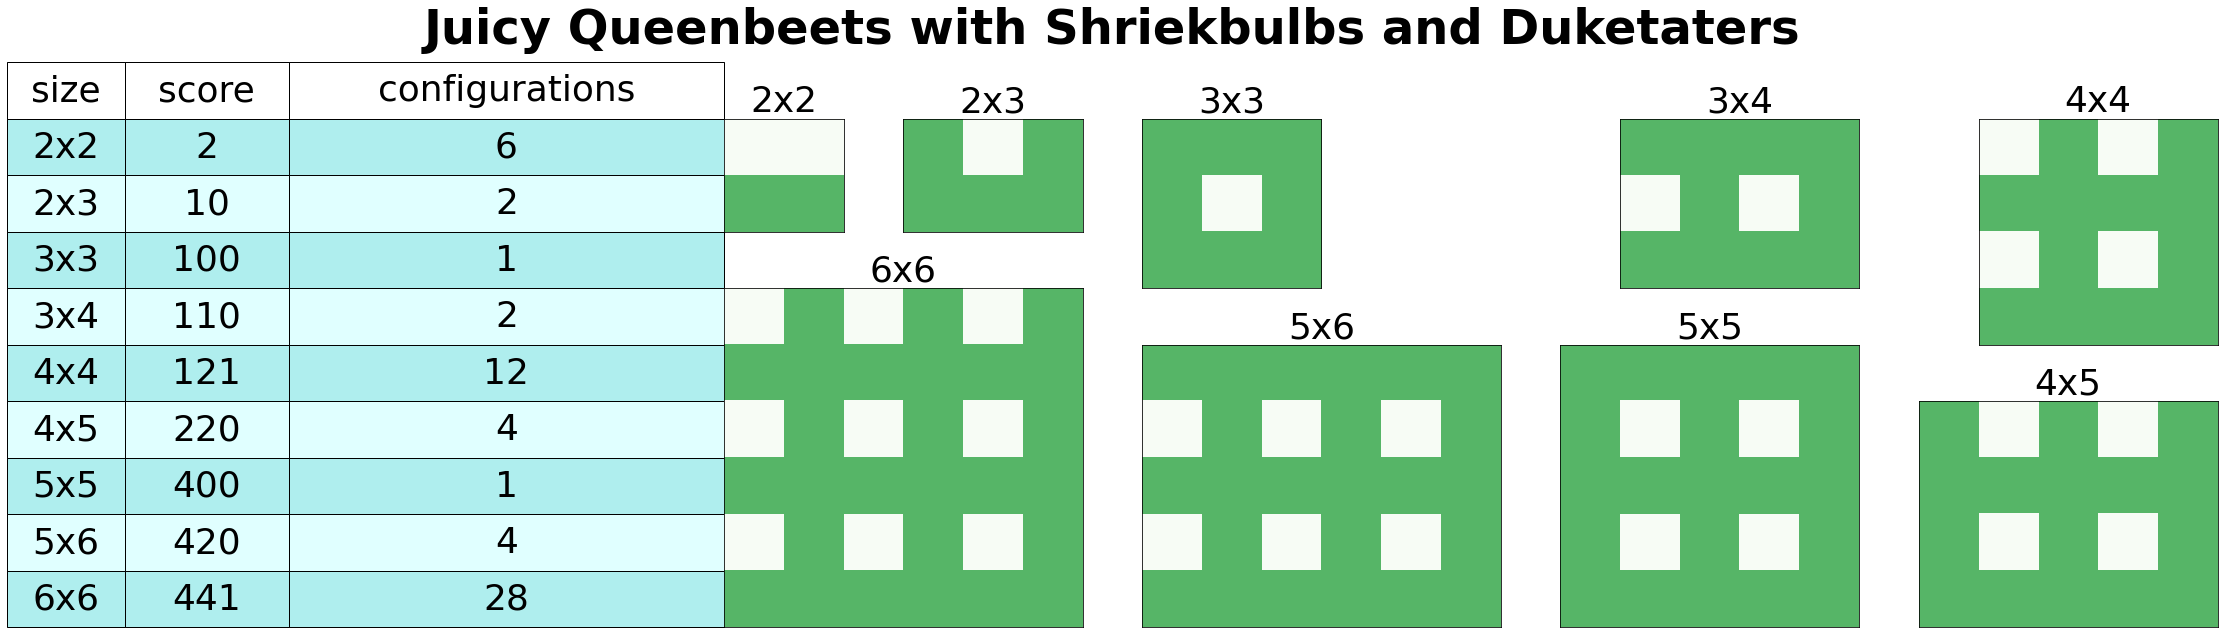

In [11]:
custom_reward = [0, 0, 1, 1, 1, 10, 10, 10, 100]
custom_neighbours = 8 # a hint for the optimizer to know how many neighbours to search for
custom_name = "Juicy Queenbeets with Shriekbulbs and Duketaters"
custom_data = build_data(custom_reward, custom_neighbours)
clear_output()
f = make_infographic(custom_data, custom_name)